In [ ]:
#menambahkan GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import files
files.upload()

Saving archive_14.zip to archive_14.zip


{'archive_14.zip': b'PK\x03\x04-\x00\x00\x00\x08\x00m\xb5^O\x88\xbf%\xc6\xff\xff\xff\xff\xff\xff\xff\xff\x19\x00\x14\x00DailyDelhiClimateTest.csv\x01\x00\x10\x00\xbc\x1b\x00\x00\x00\x00\x00\x00\x12\x08\x00\x00\x00\x00\x00\x00uY\xdd\xce\\\'\x0c\xbc\xef\xb3P\x046\xbfOSU\xca\'5\x17\x89\xa2\xfc\xa8\xea\xdb\xd7c\xd8\xc5f7l\xb5M\xce\x1a\x03\xf6\x8c\xc7\x9c|\xfa\xfb\xe7G\xf8\xf2\xf1\xf7\xd7\x9f\x1f_\xbe\x85\x7f~}\xf9\xfc\xe9\xf3\xcf\xff\xc2\xbf\x9f\xbf~\xfa\xeb\xc7\xb7\x8f\x8fO\xfa\xe3\xb7\xef\x1f?~\xfc\xfa\xfe\xf1\x07\xa5\xdc\xffLY\xfe\x0b\xb9\xc6\x999\x15.}PK\xa3\x87Q\xe3h\xb3\xb6J\xb9\xb3\xfc\x16(\xf6\xe7\xcf\xfaC\xa83\xa6\xe3\x84B\x1e\xb1\x86\xde#\xd9\x81\x89c\x167BNbK\xfd\x8cq\xfcp\xc8=f7\xc2\xc8q\xd81C\x89)73\xfa\xf2\xc9f\x94\xe3\xb3`o=\xf4\x14S\x95\xa9\xb5T\x98\xd7\xd8\x8fI\x85\t\xfbEz\x89~\xe7\x81#\'7\x18\x8e\xca\xef\xd6m!\xcf\xc8y\x98\x8f\xec\xe2~\x14Fl\xf6\xef\x83\xe04\xc7\xde\xe9\xf9\xe1\xe3T\x8eZbO\xc3.\x19\xa6\xa4\xcbn\x02\xfb\x8a\xa9\xd8\x18\x95\xe5\x95{=\xbe\x062\xdfF\xa1\x9c*5

In [ ]:
import os
import zipfile
import pandas as pd

#mengekstrak file
local_zip = '/content/archive_14.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
os.listdir('/tmp/')

['dap_multiplexer.7d277810d9c3.root.log.INFO.20210823-090031.66',
 'debugger_2ni1cobvhu',
 'dap_multiplexer.INFO',
 'DailyDelhiClimateTest.csv',
 'DailyDelhiClimateTrain.csv',
 'initgoogle_syslog_dir.0']

In [ ]:
df = pd.read_csv('/tmp/DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


In [ ]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
dates = df['date'].values
temps = df['meantemp'].values

Text(0.5, 1.0, 'Rata-Rata Temperature')

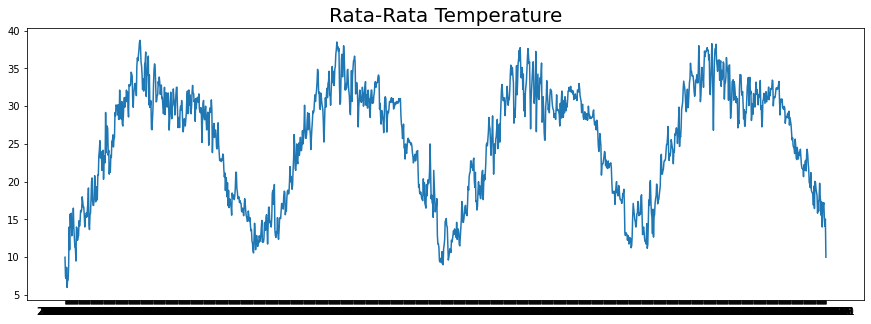

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, temps)
plt.title('Rata-Rata Temperature', fontsize=20)

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)


In [ ]:
train_set = windowed_dataset(temps, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60),
      tf.keras.layers.Dense(30, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)

])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
15/15 [==============================] - 9s 14ms/step - loss: 25.5074 - mae: 26.0074
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 25.4903 - mae: 25.9903
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 25.4701 - mae: 25.9701
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 25.4507 - mae: 25.9507
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: 25.4317 - mae: 25.9317
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 25.4129 - mae: 25.9129
Epoch 7/100
15/15 [==============================] - 0s 12ms/step - loss: 25.3943 - mae: 25.8943
Epoch 8/100
15/15 [==============================] - 0s 12ms/step - loss: 25.3757 - mae: 25.8757
Epoch 9/100
15/15 [==============================] - 0s 12ms/step - loss: 25.3567 - mae: 25.8567
Epoch 10/100
15/15 [==============================] - 0s 12ms/step - loss: 25.3360 - mae: 25.8360
Epoch 11/100
15/15 [=========